# Analyzing Character Archetypes in TV Shows and Movies

This project involves fine-tuning a pre-trained language model to classify character descriptions into archetypes such as "hero," "sidekick," "mentor," and "villain." Using Hugging Face's Transformers and a custom dataset, the model is trained to predict the archetype of a character based on a brief description. The project showcases text classification using NLP and can be deployed for users to classify new character descriptions automatically.

### Prototype

In [1]:
from transformers import pipeline 

C:\Users\lnewb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\lnewb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

In [2]:
archetypes = ["Warrior", "Child", "Orphan", "Creator", "Caregiver", "Mentor", "Joker", "Magician", "Ruler", "Rebel", "Lover", "Seducer"]

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def prototype_classify_character(character_description):
    result = classifier(character_description, candidate_labels=archetypes)
    return result['labels'][0]  # Return the highest scoring archetype

Device set to use cpu


In [3]:
# Now try on an example
character_description =\
"""
Samwise Gamgee from The Lord of the Rings is a loyal, steadfast companion to Frodo Baggins. 
He begins as a humble gardener but proves to be one of the most courageous and selfless characters in the story. 
Despite being seemingly ordinary, Sam consistently demonstrates extraordinary bravery, especially when supporting 
Frodo on their perilous journey to destroy the One Ring. His deep sense of duty, unwavering friendship, and determination 
keep him by Frodo’s side, even in the darkest moments, making him a true hero in his own right, despite never seeking fame 
or glory.
"""

In [4]:
archetype = prototype_classify_character(character_description)
print(f"The character's archetype is: {archetype}")

The character's archetype is: Caregiver


### Load dataset

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets 

In [6]:
arch_data = pd.read_csv("archetype_data.csv")

In [7]:
arch_data.head()

,description,archetype
0,A decorated general who leads an army into bat...,warrior
1,A skilled mercenary who takes on dangerous mis...,warrior
2,A young knight eager to prove themselves on th...,warrior
3,A seasoned veteran who commands a group of sol...,warrior
4,A fearless bounty hunter with a reputation for...,warrior


In [8]:
arch_data['description'][0]

'A decorated general who leads an army into battle, renowned for their tactical genius and unshakeable confidence.'

<Axes: xlabel='archetype'>

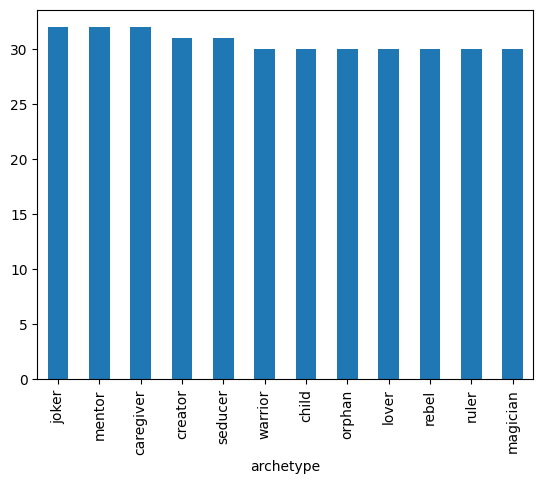

In [9]:
arch_data['archetype'].value_counts().plot(kind="bar")

In [10]:
arch_data['arch_int'] = LabelEncoder().fit_transform(arch_data['archetype'])

In [11]:
train_split, test_split = train_test_split(arch_data, train_size = 0.8)

train_df = pd.DataFrame({
    "label": train_split.arch_int.values,
    "text": train_split.description.values
})
train_df = datasets.Dataset.from_dict(train_df)

test_df = pd.DataFrame({
    "label": test_split.arch_int.values,
    "text": test_split.description.values
})
test_df = datasets.Dataset.from_dict(test_df)

dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

### Preprocess data

In [26]:
from transformers import AutoTokenizer, DataCollatorWithPadding

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [15]:
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Train model

In [23]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import accelerate

In [17]:
accuracy = evaluate.load("accuracy")

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
id2label = {
    0: "Caregiver",
    1: "Child",
    2: "Creator",
    3: "Joker",
    4: "Lover",
    5: "Magician",
    6: "Mentor",
    7: "Orphan",
    8: "Rebel",
    9: "Ruler",
    10: "Seducer",
    11: "Warrior"
}

In [20]:
label2id = {
    "Caregiver": 0,
    "Child": 1,
    "Creator": 2,
    "Joker": 3,
    "Lover": 4,
    "Magician": 5,
    "Mentor": 6,
    "Orphan": 7,
    "Rebel": 8,
    "Ruler": 9,
    "Seducer": 10,
    "Warrior": 11
}

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=12, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="archetype_ai_output",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.010020,0.500000


In [ ]:
trainer.evaluate()

In [ ]:
model.save_pretrained("archetype_ai")

## Inference

In [37]:
classify_character =  AutoModelForSequenceClassification.from_pretrained("archetype_ai")

In [41]:
new_description =\
"""
Megan from Bridesmaids is a bold, brash, and unapologetically confident 
woman who enjoys pushing boundaries and making people laugh. 
She's often the life of the party, offering her unfiltered thoughts 
and humorous insights, even in uncomfortable situations. Though she 
may come across as a bit reckless and self-serving at times, she shows 
her true loyalty and care for her friends when it counts, balancing her 
outrageous behavior with unexpected moments of warmth and sincerity.
"""

In [42]:
archetype_ai = pipeline("text-classification", model=classify_character, tokenizer=tokenizer)
archetype_ai(new_description)

Device set to use cpu


[{'label': 'Warrior', 'score': 0.10455956310033798}]